In [1]:
import numpy as np
import plotly.express as px
import random
import pandas as pd
import plotly.io as pio
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

rst = 46
np.random.seed(46)
pio.renderers.default = "colab"

/home/sebulba/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Для синтетических данных

## Генерация данных

### Инь и Янь

In [2]:
def plot_dataset(X, y, axes):
    plt.figure(figsize=(10,6))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs",alpha = 0.5)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^",alpha = 0.2)
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

In [3]:
X_m, y_m = make_moons(n_samples=1000, noise=0.2, random_state=rst)

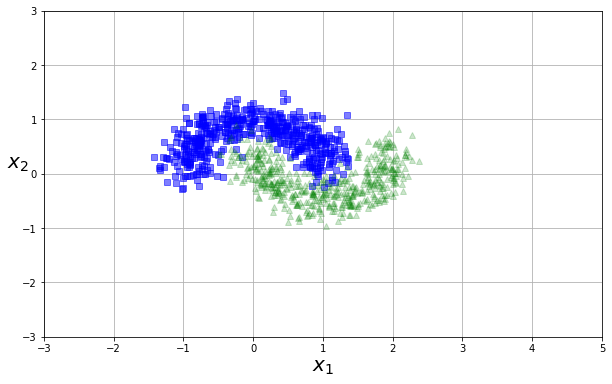

In [4]:
plot_dataset(X_m, y_m, [-3, 5, -3, 3])

### Круги

In [5]:
X_c, y_c = make_circles(n_samples=1000, noise=0.1, random_state=rst)

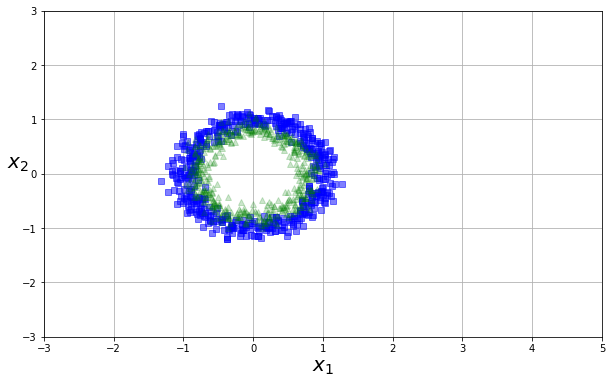

In [6]:
plot_dataset(X_c, y_c, [-3, 5, -3, 3])

## Сгенерируем полиномы и проверим типы регуляризации

В логистической регресии уже встроены методы регуляризации, поэтому нам остаётся только выяснить какой из них лучше и выбрать наиболее подходящий параметр alpha

### Инь и Янь

In [7]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.3, random_state=rst)

In [8]:
moons_scaler = MinMaxScaler()

X_train_m = moons_scaler.fit_transform(X_train_m.reshape(-1, 2))
X_test_m = moons_scaler.fit_transform(X_test_m.reshape(-1, 2))
y_train_m = moons_scaler.fit_transform(y_train_m.reshape(-1, 1)).ravel()
y_test_m = moons_scaler.fit_transform(y_test_m.reshape(-1, 1)).ravel()

#### Logreg l1 penalty

In [9]:
model_m = LogisticRegression(penalty='l1', tol=0.001, C=3, solver='liblinear').fit(X_train_m, y_train_m)

y_pred_m = model_m.predict(X_test_m)
print(classification_report(y_test_m, y_pred_m))

              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       151
         1.0       0.81      0.89      0.85       149

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



Думаю оценки классификации требуют объяснения.  Речь пойдёт о бинарной классификации. Которая у нас и есть.\
Здесь мы видим precision:
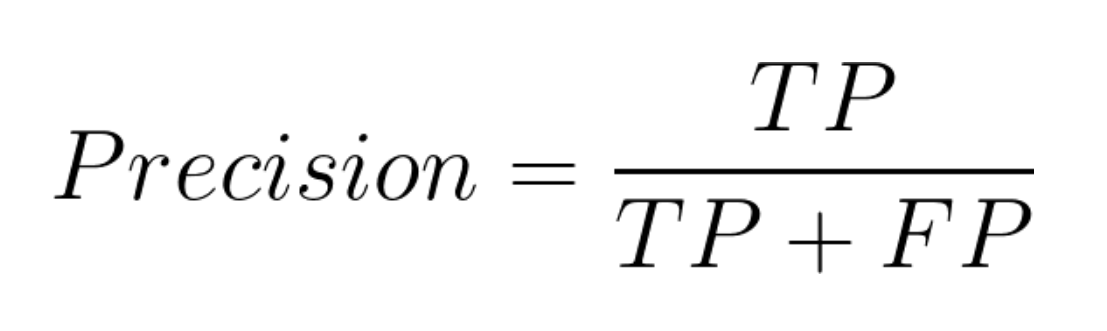\
Данная метрика показывает какую долю правильные положительные ответы (единички)
составляют от всех правильно и неправильно предугаданных единичек. Довольно стандартная метрика.

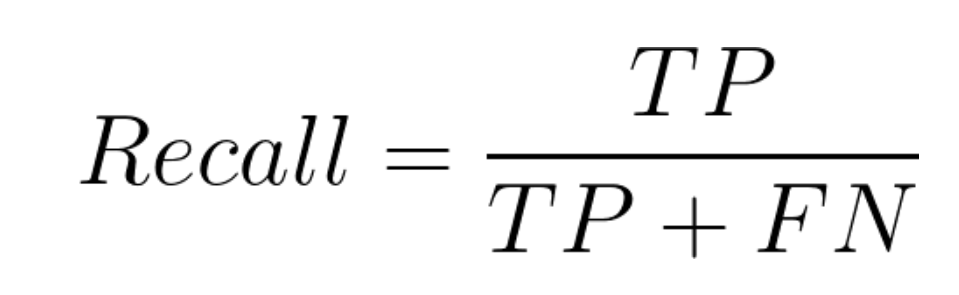

Эта же метрика даёт понять какую долю всё те же правильно отгаданные единички составляют от всех единичек, которые выдала модель. Эти метрики преобретают достаточно большую весомость и сложность, когда решается задача для бизнеса, об этом подробнее поговорим в разделе cars Moldova. 

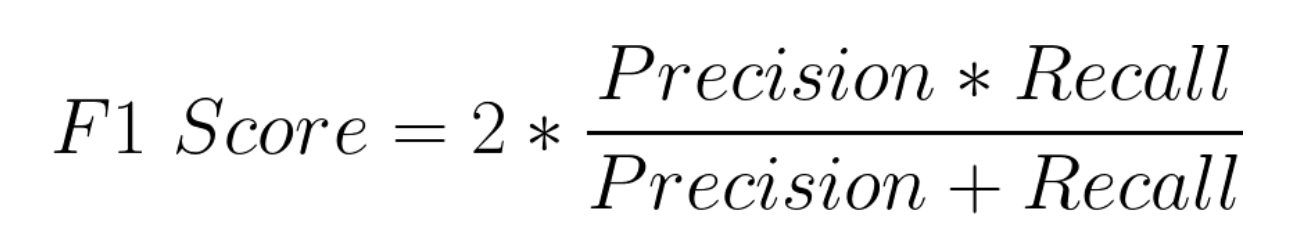

Ну и когда нам нужно получить что-то среднее между precision и recall, мы используем метрику f1 - их среднее гармоническое.



In [10]:
def plot_decision_bound(clf, X, Y):
  
  b = clf.intercept_[0]
  w1, w2 = clf.coef_.T
 
  c = -b/w2
  m = -w1/w2

  plt.figure(figsize=(15, 6))
  
  xmin, xmax = -1, 2
  ymin, ymax = -1, 2.5
  xd = np.array([xmin, xmax])
  yd = m*xd + c
  plt.plot(xd, yd, 'k', lw=1, ls='--')
  plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
  plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

  plt.scatter(*X[Y==0].T, s=8, alpha=0.5)
  plt.scatter(*X[Y==1].T, s=8, alpha=0.5)
  plt.xlim(xmin, xmax)
  plt.ylim(ymin, ymax)
  plt.ylabel(r'$x_2$')
  plt.xlabel(r'$x_1$')

  plt.show()

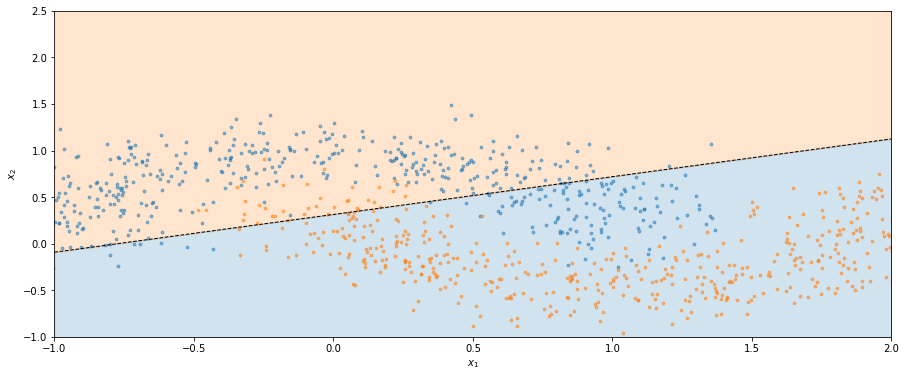

In [11]:
plot_decision_bound(model_m, X_m, y_m)

Здесь прекрасно видно, что модели не хватает полиномиальных фич, чтобы провести более кривую линию, а не как у обычной регрессии

Собственно добавим их и будем уже играться с регуляризацией

In [12]:
poly = PolynomialFeatures(degree = 5, interaction_only=False, include_bias=False)

X_train_m = poly.fit_transform(X_train_m)
X_test_m = poly.fit_transform(X_test_m)
X_m = poly.fit_transform(X_m)

In [13]:
model_m = LogisticRegression(penalty='l1', tol=0.001, C=3, solver='liblinear').fit(X_train_m, y_train_m)

y_pred_m = model_m.predict(X_test_m)
print(classification_report(y_test_m, y_pred_m))

              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       151
         1.0       0.90      0.93      0.91       149

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



Как видим, удалось сделать точность намного выше, теперь попробуем сделать что-то с регуляризацией

In [14]:
model_m = LogisticRegression(penalty='l1', tol=0.0001, C=18, solver='liblinear').fit(X_train_m, y_train_m)

y_pred_m = model_m.predict(X_test_m)
print(classification_report(y_test_m, y_pred_m))

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       151
         1.0       0.93      0.97      0.95       149

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



#### Logreg l2 penalty

Теперь попробуем регуляризацию l2

In [15]:
model_m = LogisticRegression(penalty='l2', tol=0.001, C=3, solver='lbfgs').fit(X_train_m, y_train_m)

y_pred_m = model_m.predict(X_test_m)
print(classification_report(y_test_m, y_pred_m))

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85       151
         1.0       0.82      0.90      0.86       149

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



In [16]:
model_m = LogisticRegression(penalty='l2', tol=0.0001, C=8, solver='newton-cholesky').fit(X_train_m, y_train_m)

y_pred_m = model_m.predict(X_test_m)
print(classification_report(y_test_m, y_pred_m))

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       151
         1.0       0.83      0.91      0.87       149

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300



Выглядит так себе, собственно, как мы знаем по прошлому заданию, когда дело касается каких-то линейных или полиномиальных зависимостей, нам надо занулять коэффициенты, чтобы максимально отсеч влияние заведомо неправильных функций на результат. l2 регрессия как раз таки ridge, которая не зануляет, отсюда и такие результаты.

### Круги

In [17]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.3, random_state=rst)

In [18]:
moons_scaler = MinMaxScaler()

X_train_c = moons_scaler.fit_transform(X_train_c.reshape(-1, 2))
X_test_c = moons_scaler.fit_transform(X_test_c.reshape(-1, 2))
y_train_c = moons_scaler.fit_transform(y_train_c.reshape(-1, 1)).ravel()
y_test_c = moons_scaler.fit_transform(y_test_c.reshape(-1, 1)).ravel()

#### Logreg l1 penalty

In [19]:
model_с = LogisticRegression(penalty='l1', tol=0.001, C=3, solver='liblinear').fit(X_train_c, y_train_c)

y_pred_c = model_с.predict(X_test_c)

print(classification_report(y_test_m, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.56      0.35      0.43       151
         1.0       0.52      0.72      0.60       149

    accuracy                           0.53       300
   macro avg       0.54      0.53      0.52       300
weighted avg       0.54      0.53      0.52       300



Как видим, точность здесь довольно плохая хотя бы по f1 скор 

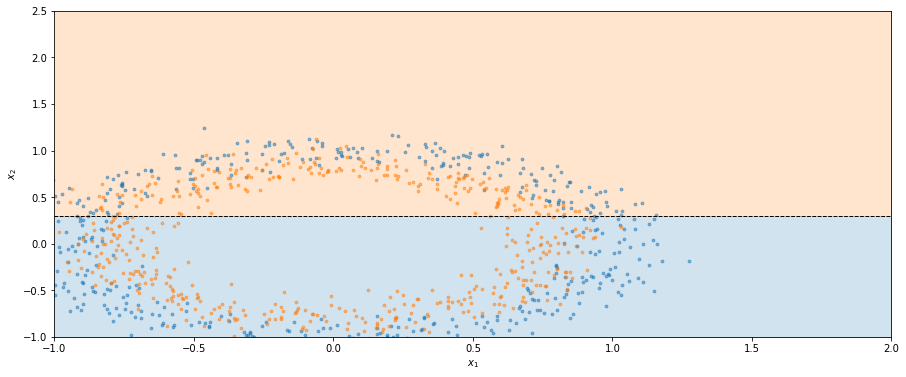

In [20]:
plot_decision_bound(model_с, X_c, y_c)

Собственно вот и причина, линия одна и делит она не совсем так как нужно

Добавим полиномиальных фичей и посмотрим на точность снова

In [21]:
X_train_c = poly.fit_transform(X_train_c)
X_test_c = poly.fit_transform(X_test_c)
X_c = poly.fit_transform(X_c)

In [22]:
model_с = LogisticRegression(penalty='l1', tol=0.001, C=3, solver='liblinear').fit(X_train_c, y_train_c)

y_pred_c = model_с.predict(X_test_c)

print(classification_report(y_test_m, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       151
         1.0       0.78      0.74      0.76       149

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



Другое дело, однако мы добавили много шума, скорее всего из-за этого точность значительно ниже чем в прошлом датасете.

In [23]:
model_с = LogisticRegression(penalty='l1', tol=0.0001, C=3, solver='liblinear').fit(X_train_c, y_train_c)

y_pred_c = model_с.predict(X_test_c)

print(classification_report(y_test_m, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78       151
         1.0       0.78      0.74      0.76       149

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



/home/sebulba/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Видим, что точность особо не повышается, попробуем другой параметр solver

In [24]:
model_с = LogisticRegression(penalty='l1', tol=0.001, C=3, solver='saga').fit(X_train_c, y_train_c)

y_pred_c = model_с.predict(X_test_c)

print(classification_report(y_test_m, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       151
         1.0       0.78      0.74      0.76       149

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



/home/sebulba/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Стало только хуже

#### Logreg l2 penalty

Сразу предположу, что будет хуже, ранее описывал, что данная задача предполагает, что ridge регрессия отработает хуже, но это надо ещё проверить.

In [25]:
model_с = LogisticRegression(penalty='l2', tol=0.001, C=3, solver='lbfgs').fit(X_train_c, y_train_c)

y_pred_c = model_с.predict(X_test_c)

print(classification_report(y_test_m, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75       151
         1.0       0.74      0.78      0.76       149

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



Интересно, моя гипотиза подтвердилась, однако точность f1 не так сильно и хуже.

In [26]:
model_с = LogisticRegression(penalty='l2', tol=0.001, C=19, solver='lbfgs').fit(X_train_c, y_train_c)

y_pred_c = model_с.predict(X_test_c)

print(classification_report(y_test_m, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       151
         1.0       0.78      0.74      0.76       149

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



Видим, что значения немного хуже, это в большинстве своём из-за шума в данных, который мы сделали большим, а  также из-за того, что области, которые мы пытаемся делить заходят друг на друга.

## Вывод

Мы выяснили, что логистическая регресиия может классифицировать данные используя регуляризацию, Lasso регуляризация в данном случае отработала лучше всего, так как всё-таки, нужно обнулять лишиние фичи

# Для набора данных Cars Moldova:

Из прошлого задания возьмём датасеты с предварительной обработкой

In [27]:
df_norm = pd.read_csv('cars_moldova_norm.csv').drop(columns=['Unnamed: 0'])
df_norm

,Year,Distance,Engine_capacity(cm3),Price(euro),year_distance,Transmission_Automatic,Transmission_Manual,Model_1 Series,Model_100,Model_1007,...,distance_type_average,distance_type_high,distance_type_optimal,distance_type_very_high,Make_rarity_common,Make_rarity_rare,Price_cat_average,Price_cat_cheap,Year_category_old,Year_category_regular
0,0.836066,0.195000,0.360288,7700.0,6.331169e-02,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
1,0.885246,0.135000,0.300240,8500.0,6.026786e-02,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
2,0.622951,0.000001,0.280224,2200.0,1.488095e-07,0,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
3,0.852459,0.110000,0.300240,6500.0,3.928571e-02,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
4,0.754098,0.200000,0.320256,4100.0,4.464286e-02,0,1,0,0,0,...,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35964,0.688525,0.225000,0.360288,4400.0,4.017857e-02,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
35965,0.901639,0.089000,0.300240,7000.0,4.540816e-02,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
35966,0.803279,0.000225,0.300240,4500.0,6.181319e-05,0,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
35967,0.754098,0.370000,0.400320,4000.0,8.258929e-02,0,1,0,0,0,...,0,0,0,1,0,1,1,0,1,0


In [28]:
df_st = pd.read_csv('cars_moldova_stand.csv').drop(columns=['Unnamed: 0'])
df_st

,Year,Distance,Engine_capacity(cm3),Price(euro),year_distance,Transmission_Automatic,Transmission_Manual,Model_1 Series,Model_100,Model_1007,...,distance_type_average,distance_type_high,distance_type_optimal,distance_type_very_high,Make_rarity_common,Make_rarity_rare,Price_cat_average,Price_cat_cheap,Year_category_old,Year_category_regular
0,0.419955,0.285702,-0.046315,7700.0,0.481595,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
1,0.820193,-0.274774,-0.525630,8500.0,0.384476,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
2,-1.314409,-1.535836,-0.685401,2200.0,-1.538493,0,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
3,0.553368,-0.508306,-0.525630,6500.0,-0.285004,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
4,-0.247108,0.332408,-0.365858,4100.0,-0.114073,0,1,0,0,0,...,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35964,-0.780758,0.565940,-0.046315,4400.0,-0.256515,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
35965,0.953606,-0.704473,-0.525630,7000.0,-0.089654,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
35966,0.153130,-1.533744,-0.525630,4500.0,-1.536525,0,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
35967,-0.247108,1.920424,0.273228,4000.0,1.096688,0,1,0,0,0,...,0,0,0,1,0,1,1,0,1,0


In [29]:
df_st_norm = pd.read_csv('cars_moldova_norm_and_stand.csv').drop(columns=['Unnamed: 0'])
df_st_norm

,Year,Distance,Engine_capacity(cm3),Price(euro),year_distance,Transmission_Automatic,Transmission_Manual,Model_1 Series,Model_100,Model_1007,...,distance_type_average,distance_type_high,distance_type_optimal,distance_type_very_high,Make_rarity_common,Make_rarity_rare,Price_cat_average,Price_cat_cheap,Year_category_old,Year_category_regular
0,0.419955,0.285702,0.360288,7700.0,0.481595,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
1,0.820193,-0.274774,0.300240,8500.0,0.384476,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
2,-1.314409,-1.535836,0.280224,2200.0,-1.538493,0,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
3,0.553368,-0.508306,0.300240,6500.0,-0.285004,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
4,-0.247108,0.332408,0.320256,4100.0,-0.114073,0,1,0,0,0,...,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35964,-0.780758,0.565940,0.360288,4400.0,-0.256515,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
35965,0.953606,-0.704473,0.300240,7000.0,-0.089654,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
35966,0.153130,-1.533744,0.300240,4500.0,-1.536525,0,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0
35967,-0.247108,1.920424,0.400320,4000.0,1.096688,0,1,0,0,0,...,0,0,0,1,0,1,1,0,1,0


Поделим решение задачи на несколько блоков в соответствии с нашими данными 

## Нормализованные данные

Как и обычно, сделаем разделение на тестовую и тренировочную выборки, но в этот раз попробуем сделать 0.3 долю тестовой выборки

In [30]:
df_norm['Transmission'] = pd.from_dummies(df_norm[['Transmission_Automatic','Transmission_Manual']])
df_norm['Transmission'] = df_norm.Transmission.apply(lambda x: x.split('_')[1])
df_norm = df_norm.drop(columns=['Transmission_Automatic','Transmission_Manual'])

In [31]:
X = df_norm.drop(columns='Transmission')
y = df_norm.Transmission

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rst)

#### LogReg l2 penalty


In [33]:
model_norm = LogisticRegression(penalty='l2', C=6, tol=0.0001).fit(X_train, y_train)

y_pred = model_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.84      0.75      0.79      4769
      Manual       0.82      0.89      0.85      6022

    accuracy                           0.83     10791
   macro avg       0.83      0.82      0.82     10791
weighted avg       0.83      0.83      0.82     10791



Видим точность и можно сказать сразу, что в данной бизнес задаче нет положительного и плохого класса, так что мы должны смотреть на метрику f1, так как она будет лучше всего описывать правильность расчёта классов модели, нам важно, чтобы высокая точность была и по механическим и по автоматическим коробкам передач

Можно сказать, что модель отработала неплохо, попробуем чутка увеличить точность ради интереса

In [34]:
model_norm = LogisticRegression(penalty='l2', C=70, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.79      0.72      0.76      4769
      Manual       0.79      0.85      0.82      6022

    accuracy                           0.79     10791
   macro avg       0.79      0.79      0.79     10791
weighted avg       0.79      0.79      0.79     10791



Ничего не получается, посмотрим на веса, тогда будет ясно в чём дело

In [35]:
def plot_weights(coefs, columns=None, show_cols=False):
  df_plot = pd.DataFrame()

  df_plot['y'] = coefs.squeeze()
  if show_cols:
    df_plot['x'] = columns
  else:
    df_plot['x'] = ['w' + str(s) for s in range(len(coefs.squeeze()))]
  df_plot['c'] = df_plot.y.apply(lambda x: '>=0' if x >= 0 else '<0')


  return px.bar(df_plot, y='y', x='x', color='c', color_discrete_map={'>=0': 'blue', '<0': 'red'}).update_xaxes(categoryorder='array', categoryarray=df_plot['x'])

In [36]:
plot_weights(model_norm.coef_, columns=X.columns, show_cols=True)

Здесь мы видим довольно хорошую картину с точки зрения обучения, нам помогли колонки, которые мы создавали самостоятельно, они очень весомые

#### LogReg l1 penalty

In [37]:
model_norm = LogisticRegression(penalty='l1', C=6, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.88      0.80      0.84      4769
      Manual       0.85      0.91      0.88      6022

    accuracy                           0.86     10791
   macro avg       0.87      0.86      0.86     10791
weighted avg       0.86      0.86      0.86     10791



Итак, мы видим, что Lasso сходу отработала лучше, а это значит, что веса наших моделей автомобилей почему-то не влияют на определение типа коробки передач

In [38]:
model_norm = LogisticRegression(penalty='l1', C=4, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.88      0.80      0.84      4769
      Manual       0.85      0.91      0.88      6022

    accuracy                           0.86     10791
   macro avg       0.86      0.86      0.86     10791
weighted avg       0.86      0.86      0.86     10791



Изначальное число сужения фич было довольно хорошим для точности, взглянем на веса

In [39]:
plot_weights(model_norm.coef_, columns=X.columns, show_cols=True)

Итак, оказывается, если равномерно дадим веса типам автомобилей и маркам, то мы также сможем предсказать тип коробки передач, оба варианта хороши, но по маркам и моделям работает лучше, потому что там лучше зависимость

## Стандартизованные данные

In [40]:
df_st['Transmission'] = pd.from_dummies(df_st[['Transmission_Automatic','Transmission_Manual']])
df_st['Transmission'] = df_st.Transmission.apply(lambda x: x.split('_')[1])
df_st = df_st.drop(columns=['Transmission_Automatic','Transmission_Manual'])

In [41]:
X = df_st.drop(columns='Transmission')
y = df_st.Transmission

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rst)

#### LogReg l2 penalty


In [43]:
model_st = LogisticRegression(penalty='l2', C=6, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.85      0.77      0.81      4769
      Manual       0.83      0.89      0.86      6022

    accuracy                           0.84     10791
   macro avg       0.84      0.83      0.83     10791
weighted avg       0.84      0.84      0.84     10791



Видим, что точность ниже, чем у прошлой предобработки данных

In [44]:
model_st = LogisticRegression(penalty='l2', C=19, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.85      0.77      0.81      4769
      Manual       0.83      0.89      0.86      6022

    accuracy                           0.84     10791
   macro avg       0.84      0.83      0.83     10791
weighted avg       0.84      0.84      0.84     10791



In [45]:
plot_weights(model_st.coef_, columns=X.columns, show_cols=True)

Видим, что предобработка дала о себе знать, главные характеристики: год, пробег и объём двигателя улетели в минуса, а те, что мы сгенерировали лидируют

#### LogReg l1 penalty

Посмотрим, что даст Lasso регуляризация

In [46]:
model_st = LogisticRegression(penalty='l1', C=6, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.87      0.80      0.84      4769
      Manual       0.85      0.91      0.88      6022

    accuracy                           0.86     10791
   macro avg       0.86      0.86      0.86     10791
weighted avg       0.86      0.86      0.86     10791



Результат идентичен результату Lasso  на полной нормализации

In [47]:
model_st = LogisticRegression(penalty='l1', C=56, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.87      0.81      0.84      4769
      Manual       0.85      0.91      0.88      6022

    accuracy                           0.86     10791
   macro avg       0.86      0.86      0.86     10791
weighted avg       0.86      0.86      0.86     10791



Удалось увеличить метрику recall на автоматической коробке передач как на положительном классе, однако нам всё ещё предпочтительно смотреть на f1 score

Посмотрим какие веса дала модель 

In [48]:
plot_weights(model_st.coef_, columns=X.columns, show_cols=True)

Здесь повлияли марки автомобилей, как и в случае с нормализацией.\

Теперь ясно почему модель отработала при том и другом случае одинаково, предобработка не применялась к закодированным категориальным данным, из-за чего они просто считай не участвовали.

## Стандартизованные и Нормализованные данные

In [49]:
df_st_norm['Transmission'] = pd.from_dummies(df_st_norm[['Transmission_Automatic','Transmission_Manual']])
df_st_norm['Transmission'] = df_st_norm.Transmission.apply(lambda x: x.split('_')[1])
df_st_norm = df_st_norm.drop(columns=['Transmission_Automatic','Transmission_Manual'])

In [50]:
X = df_st_norm.drop(columns='Transmission')
y = df_st_norm.Transmission

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rst)

#### LogReg l2 penalty


In [52]:
model_st_norm = LogisticRegression(penalty='l2', C=6, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.83      0.74      0.79      4769
      Manual       0.81      0.88      0.85      6022

    accuracy                           0.82     10791
   macro avg       0.82      0.81      0.82     10791
weighted avg       0.82      0.82      0.82     10791



странно, но на чистой нормализации общая точность на 0.01 выше

In [53]:
model_st_norm = LogisticRegression(penalty='l2', C=2, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.83      0.74      0.79      4769
      Manual       0.81      0.88      0.85      6022

    accuracy                           0.82     10791
   macro avg       0.82      0.81      0.82     10791
weighted avg       0.82      0.82      0.82     10791



Ничего не меняется, посмотрим на веса

In [54]:
plot_weights(model_st_norm.coef_, columns=X.columns, show_cols=True)

Итак, в данном случае модель максимально уменьшила значение фич, которые плохо влияют на результат, и мы видим, что опять отработали хорошо новые фичи, которые были внесены в первом задании

#### LogReg l1 penalty

In [55]:
model_st_norm = LogisticRegression(penalty='l1', C=6, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.87      0.80      0.84      4769
      Manual       0.85      0.91      0.88      6022

    accuracy                           0.86     10791
   macro avg       0.86      0.86      0.86     10791
weighted avg       0.86      0.86      0.86     10791



Ситуация повторяется, для проверки, попробуем подвигать параметр сжатия

In [56]:
model_st_norm = LogisticRegression(penalty='l1', C=56, tol=0.0001, solver='liblinear').fit(X_train, y_train)

y_pred = model_st_norm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Automatic       0.87      0.81      0.84      4769
      Manual       0.85      0.91      0.88      6022

    accuracy                           0.86     10791
   macro avg       0.86      0.86      0.86     10791
weighted avg       0.86      0.86      0.86     10791



Та же картина, что и раньше

Взглянем на веса

In [57]:
plot_weights(model_st.coef_, columns=X.columns, show_cols=True)

То же самое

# Вывод

Что мы видим, ситуация с обучением довольно сильно повторяется, мы можем прогнозировать тип коробки передач по моделям автомобилей, однако, если смотреть в будущее данный способ будет плох, так как модели поменяются на другие.

Поэтому ради точности в ближайшее время можно прогнозировать по моделям, но также помнить, что если мы возьмём полную стандартизацию числовых признаков и ridge регуляризацию, то мы получим точность немного ниже, зато теперь, когда будут приходить новые данные, мы сможем определять тип кпп по признакам, которые не меняются.